# Amazon SageMaker 

# <a name="0">Sample Note Book: Feature Engineering, Gradient Boosting Model, and Hyperparameter Tuning</a>


## Random Forest Tree Model 

In this notebook, we build, train, and tune by [__GridSearchCV__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) a [Gradient Boosting Classifier__](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) to predict the __target_label__ field (default or no default) of Credit Cards from UCI dataset. 

1. <a href="#1">Read the dataset</a>
2. <a href="#2">Exploratory Data Analysis</a>
3. <a href="#3">Select features to build the model</a>
4. <a href="#4">Resample Dataset</a>
4. <a href="#5">Training and test datasets</a>
5. <a href="#6">Data processing with Pipeline and ColumnTransformer</a>
6. <a href="#7">Train and tune a classifier</a>
7. <a href="#8">Test the classifier</a>



## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

Let's read the dataset into a dataframe, using Pandas.

In [1]:
import numpy as np                                
import matplotlib.pyplot as plt   
from IPython.display import Image                 
from IPython.display import display               
from sklearn.datasets import dump_svmlight_file   
from time import gmtime, strftime                 
import sys                                        
import math                                       
import json

In [2]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
  
df = pd.read_csv('../input/dataset/default of credit card clients.csv', error_bad_lines=False)

print('The shape of the training dataset is:', df.shape)

The shape of the training dataset is: (30000, 25)


## 2. <a name="2">Exploratory Data Analysis</a>
(<a href="#0">Go to top</a>)

We look at number of rows, columns and some simple statistics of the dataset.

In [3]:
# Print the first five rows
# NaN means missing data
df.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,female,university,married,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,female,university,single,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,female,university,single,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,female,university,married,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,male,university,married,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,male,graduate school,single,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,male,graduate school,single,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,female,university,single,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,female,others,married,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,male,high school,single,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [4]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  int64 
 1   LIMIT_BAL                   30000 non-null  int64 
 2   SEX                         30000 non-null  object
 3   EDUCATION                   29669 non-null  object
 4   MARRIAGE                    29677 non-null  object
 5   AGE                         30000 non-null  int64 
 6   PAY_0                       30000 non-null  int64 
 7   PAY_2                       30000 non-null  int64 
 8   PAY_3                       30000 non-null  int64 
 9   PAY_4                       30000 non-null  int64 
 10  PAY_5                       30000 non-null  int64 
 11  PAY_6                       30000 non-null  int64 
 12  BILL_AMT1                   30000 non-null  int64 
 13  BILL_AMT2                   30000 non-null  in

In [5]:
# This will print basic statistics for numerical columns
df.describe()

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,35.518833,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,9.528019,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,267.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


#### Target distribution

Let's check our target distribution.

We can see from the target plot above that we are dealing with an imbalanced dataset. This means one result type is dominating the other one(s). But this is a regression model, and no issue for this data set

In [6]:
# Number of unique elements in dataset
df.nunique()

ID                            30000
LIMIT_BAL                        81
SEX                               2
EDUCATION                         5
MARRIAGE                          3
AGE                              63
PAY_0                            11
PAY_2                            11
PAY_3                            11
PAY_4                            11
PAY_5                            10
PAY_6                            10
BILL_AMT1                     22723
BILL_AMT2                     22346
BILL_AMT3                     22026
BILL_AMT4                     21548
BILL_AMT5                     21010
BILL_AMT6                     20604
PAY_AMT1                       7943
PAY_AMT2                       7899
PAY_AMT3                       7518
PAY_AMT4                       6937
PAY_AMT5                       6897
PAY_AMT6                       6939
default payment next month        2
dtype: int64

In [7]:
# What columns are in dataset?
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

Text(0.5, 1.0, 'dataset correlation')

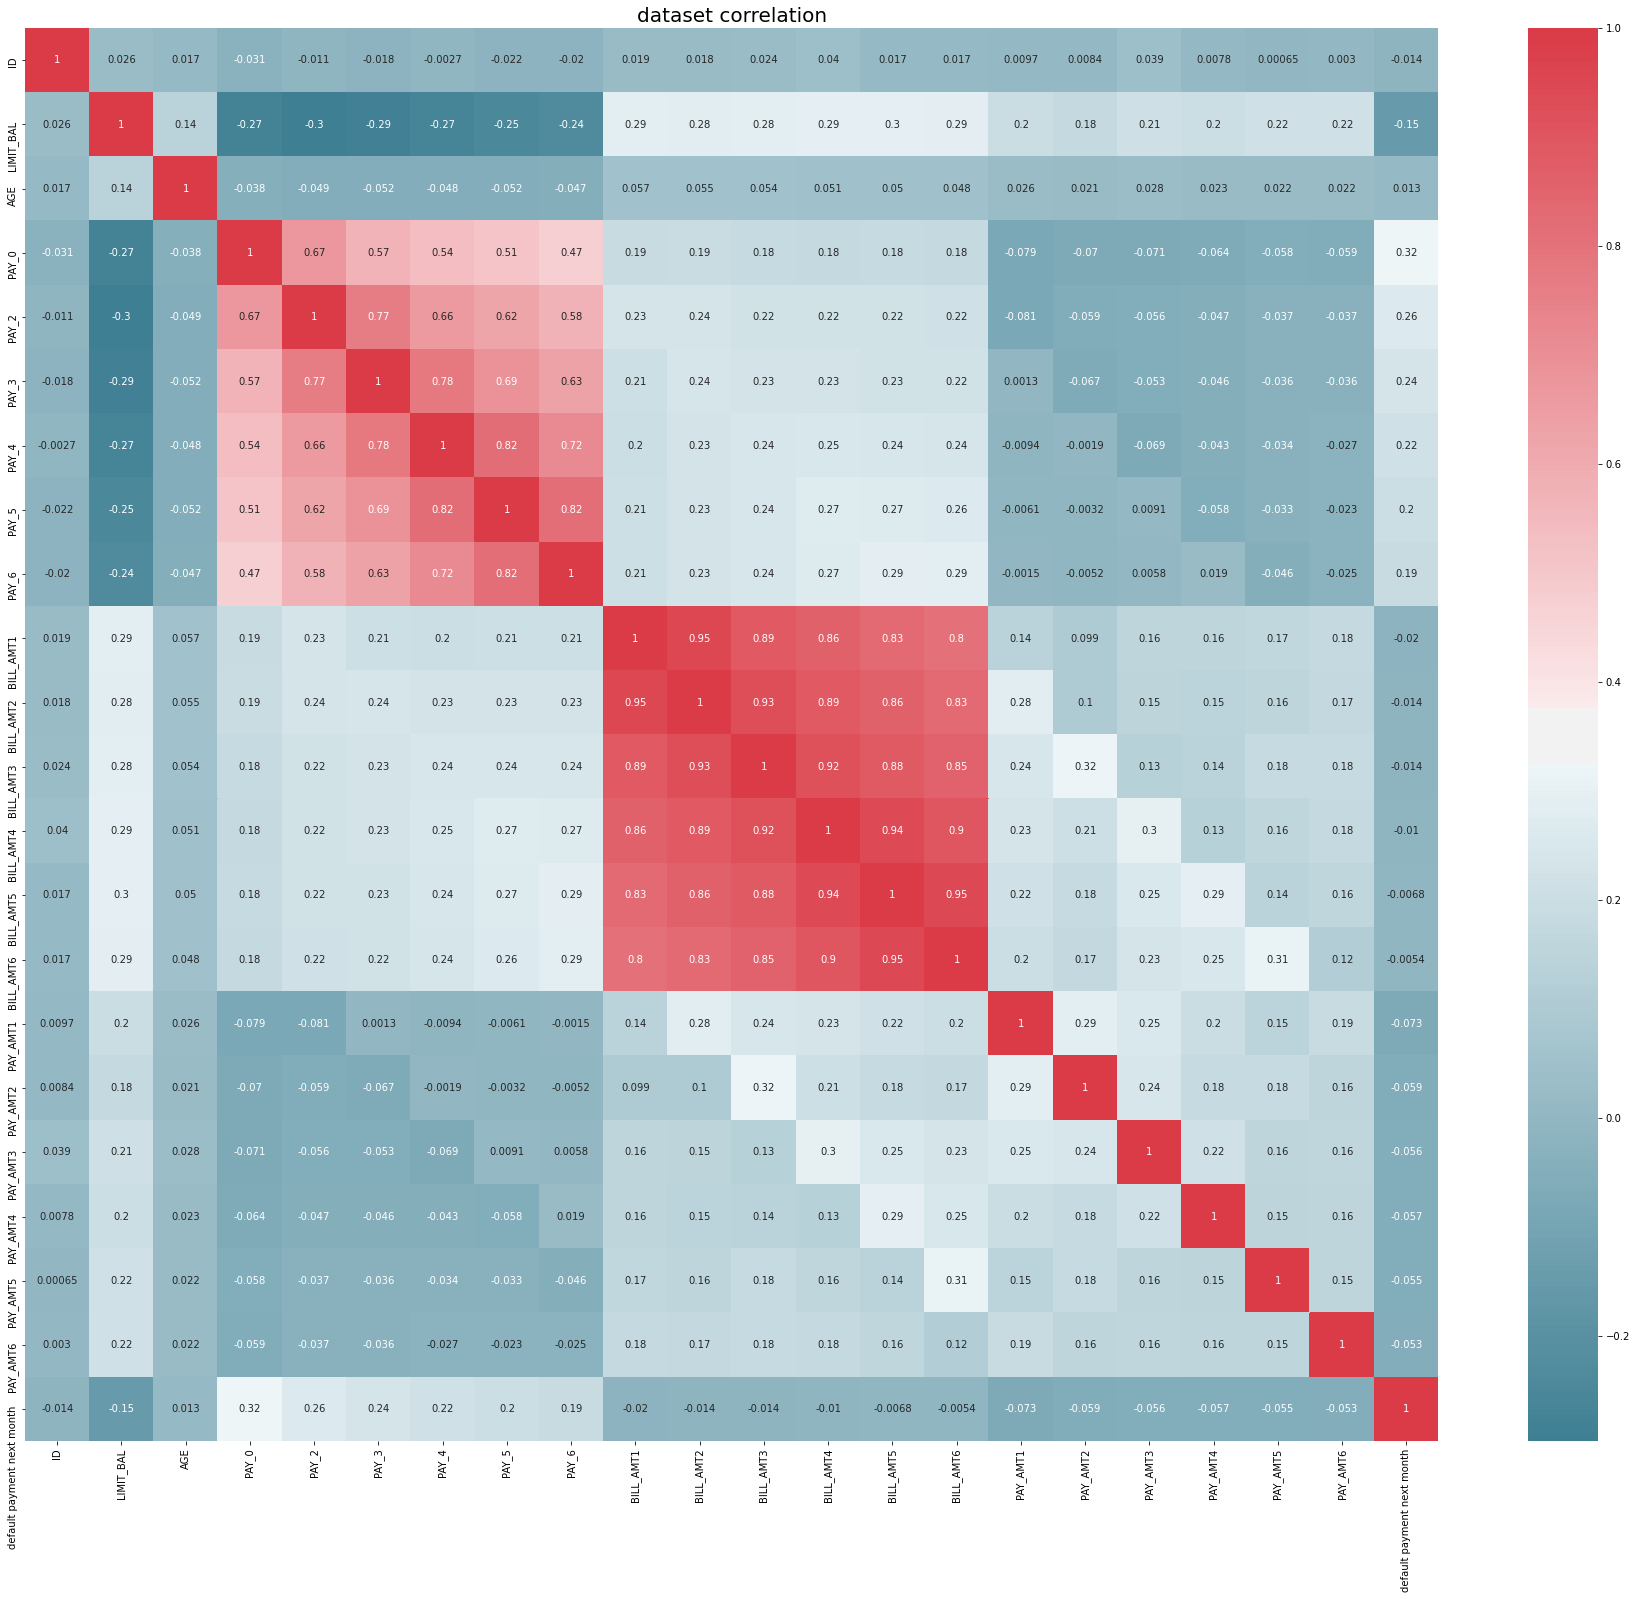

In [8]:
# Display correlation after removing correlated features
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(32, 26))
corr = df.corr()
mp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot = True)
mp.set_title(label='dataset correlation', fontsize=20)

In [9]:
text_categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

numeric_categorical_features =  [ 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

numeric_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

non_useful_features = ['ID']

label_feature = ['default payment next month']

In [10]:
text_categorical_features = [col for col in df.select_dtypes(include = 'object').columns]

In [11]:
print([col for col in df.select_dtypes(include = 'object').columns])

['SEX', 'EDUCATION', 'MARRIAGE']


In [12]:
df[numeric_features].head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [13]:
df[text_categorical_features].nunique()

SEX          2
EDUCATION    5
MARRIAGE     3
dtype: int64

In [14]:
df[numeric_categorical_features].nunique()

PAY_0    11
PAY_2    11
PAY_3    11
PAY_4    11
PAY_5    10
PAY_6    10
dtype: int64

In [15]:
df[numeric_features].nunique()

LIMIT_BAL       81
AGE             63
BILL_AMT1    22723
BILL_AMT2    22346
BILL_AMT3    22026
BILL_AMT4    21548
BILL_AMT5    21010
BILL_AMT6    20604
PAY_AMT1      7943
PAY_AMT2      7899
PAY_AMT3      7518
PAY_AMT4      6937
PAY_AMT5      6897
PAY_AMT6      6939
dtype: int64

In [16]:
#remove duplicates
df.drop_duplicates(inplace=True)

In [17]:
#drop non necessary columns
#dfc.drop(features_drop, axis=1, inplace=True)
#dfc_t.drop(features_drop, axis=1, inplace=True)

## 3. <a name="3">Select features to build the model</a>
(<a href="#0">Go to top</a>)

We build a model using selected features (except __ID, Name, Links__). That is, we build a regressor including __numerical, and categorical__  features. 

In [18]:
label = 'default payment next month'

In [19]:
all_features = numeric_features + text_categorical_features + numeric_categorical_features + label_feature #+ date_features

In [20]:
print('Numerical categorial columns:', df[numeric_categorical_features].select_dtypes(include=np.number).columns)
print('Numerical            columns:', df[numeric_features].select_dtypes(include=np.number).columns)
print('Text   Categorical columns:',df[text_categorical_features].select_dtypes(include='object').columns)

Numerical categorial columns: Index(['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], dtype='object')
Numerical            columns: Index(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')
Text   Categorical columns: Index(['SEX', 'EDUCATION', 'MARRIAGE'], dtype='object')


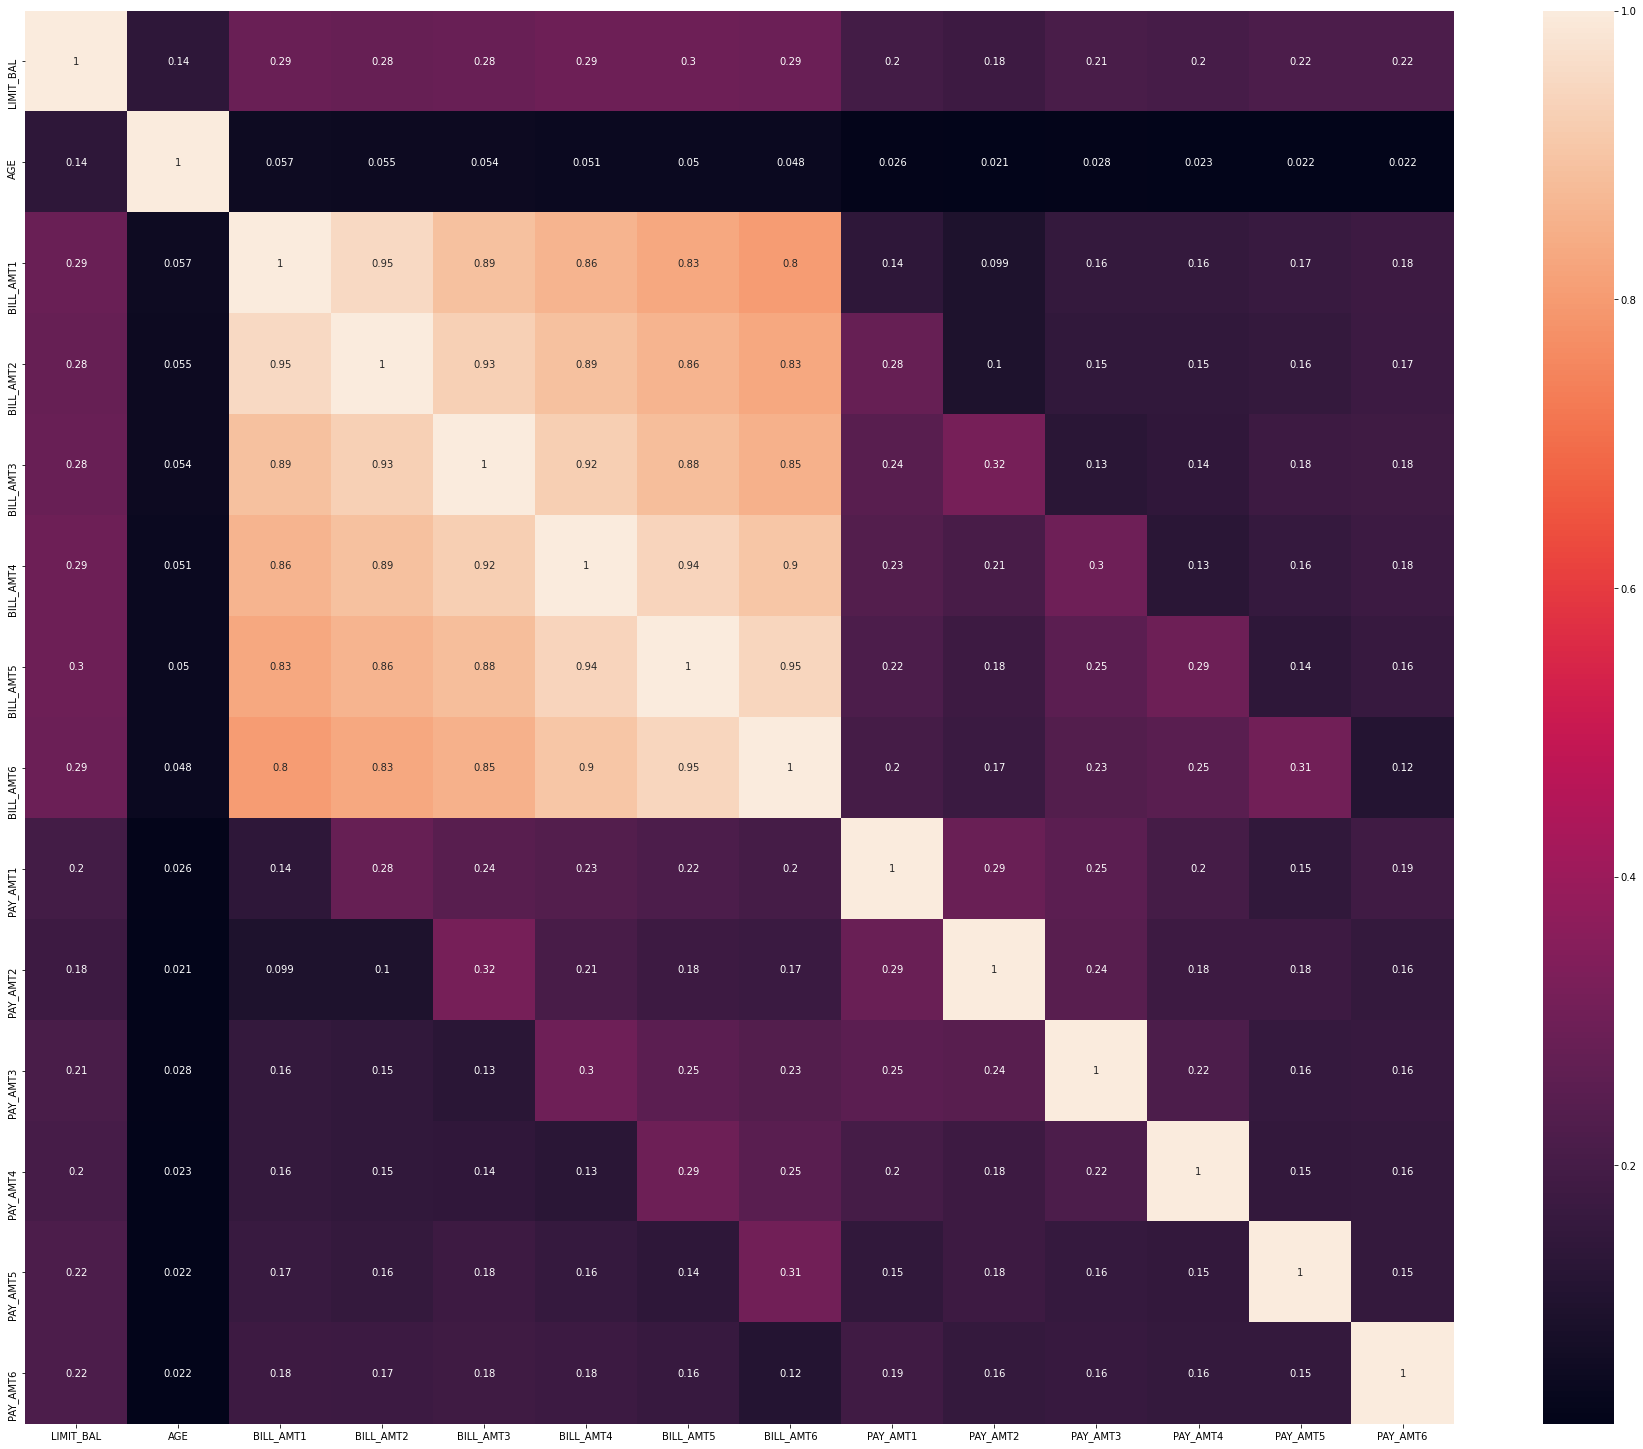

In [21]:
# Display correlation after removing correlated features
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(32, 26))
# corr = df[numeric_features].corr()
sns.heatmap(df[numeric_features].corr(), annot = True)
# mp.set_title(label='dataset correlation', fontsize=20)

#### checking for numerical features outliers

In [22]:
for c in numeric_features:
    print(c)
    print(df[c].value_counts(bins=10, sort=False))

LIMIT_BAL
(9009.999, 109000.0]     12498
(109000.0, 208000.0]      7880
(208000.0, 307000.0]      5059
(307000.0, 406000.0]      2759
(406000.0, 505000.0]      1598
(505000.0, 604000.0]       127
(604000.0, 703000.0]        56
(703000.0, 802000.0]        22
(802000.0, 901000.0]         0
(901000.0, 1000000.0]        1
Name: LIMIT_BAL, dtype: int64
AGE
(20.753, 45.6]    25327
(45.6, 70.2]       4651
(70.2, 94.8]         15
(94.8, 119.4]         0
(119.4, 144.0]        2
(144.0, 168.6]        2
(168.6, 193.2]        0
(193.2, 217.8]        0
(217.8, 242.4]        2
(242.4, 267.0]        1
Name: AGE, dtype: int64
BILL_AMT1
(-166710.09199999998, -52570.9]        2
(-52570.9, 60438.2]                21885
(60438.2, 173447.3]                 6007
(173447.3, 286456.4]                1534
(286456.4, 399465.5]                 397
(399465.5, 512474.6]                 143
(512474.6, 625483.7]                  27
(625483.7, 738492.8]                   3
(738492.8, 851501.9]                   1
(85

In [23]:
df = df[df["AGE"] < 100]

In [24]:
for c in numeric_features:
    print(c)
    print(df[c].value_counts(bins=10, sort=False))

LIMIT_BAL
(9009.999, 109000.0]     12495
(109000.0, 208000.0]      7879
(208000.0, 307000.0]      5059
(307000.0, 406000.0]      2758
(406000.0, 505000.0]      1596
(505000.0, 604000.0]       127
(604000.0, 703000.0]        56
(703000.0, 802000.0]        22
(802000.0, 901000.0]         0
(901000.0, 1000000.0]        1
Name: LIMIT_BAL, dtype: int64
AGE
(20.941, 26.8]    5126
(26.8, 32.6]      8260
(32.6, 38.4]      6513
(38.4, 44.2]      4811
(44.2, 50.0]      3016
(50.0, 55.8]      1424
(55.8, 61.6]       628
(61.6, 67.4]       170
(67.4, 73.2]        40
(73.2, 79.0]         5
Name: AGE, dtype: int64
BILL_AMT1
(-166710.09199999998, -52570.9]        2
(-52570.9, 60438.2]                21881
(60438.2, 173447.3]                 6006
(173447.3, 286456.4]                1532
(286456.4, 399465.5]                 397
(399465.5, 512474.6]                 143
(512474.6, 625483.7]                  27
(625483.7, 738492.8]                   3
(738492.8, 851501.9]                   1
(851501.9, 96

Let's check missing values for these numerical features.

In [25]:
print(df[numeric_features].isna().sum())

LIMIT_BAL    0
AGE          0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dtype: int64


As a quick fix, we will apply mean imputation. This will replace the missing values with the mean value of the corresponding column.

__Note__: The statistically correct way to perform mean/mode imputation before training an ML model is to compute the column-wise means on the training data only, and then use these values to impute missing data in both the train and test sets. So, we'll need to split our dataset first. Same goes for any other transformations we would like to apply to these numerical features, such as scaling. 

#### Cleaning categorical features 

Let's also examine the categorical features.

In [26]:
for c in text_categorical_features:
    print(c)
    print(df[c].unique()) #value_counts())

SEX
['female' 'male']
EDUCATION
['university' 'graduate school' 'others' 'high school' nan '0']
MARRIAGE
['married' 'single' nan '0']


In [27]:
df[text_categorical_features] = df[text_categorical_features].astype('str')

In [28]:
df[numeric_categorical_features] = df[numeric_categorical_features].astype('str')

In [29]:
df[numeric_features] = df[numeric_features].astype('float32')

In [30]:
df[label_feature] = df[label_feature].astype('int')

__Note on boolean type__: Most categories are strings, except the __nan__s, and the booleans __False__ and __True__. The booleans will raise errors when trying to encode the categoricals with sklearn encoders, none of which accept boolean types. If using pandas get_dummies to one-hot encode the categoricals, there's no need to convert the booleans. However, get_dummies is trickier to use with sklearn's Pipeline and GridSearch. 

One way to deal with the booleans is to convert them to strings, by using a mask and a map changing only the booleans.

The current data set doesn't have booleans, but here is a sample code

mask = df.applymap(type) != bool

do = {True: 'TRUE', False: 'FALSE'}

df_masked = df.where(mask, df.replace(do))

Another way to handle the booleans is to convert them to strings by changing the type of all categoricals to 'str'. This will also affect the nans, basically performing imputation of the nans with a 'nans' placeholder value! 

Applying the type conversion to both categoricals and text features, takes care of the nans in the text fields as well. In case other imputations are planned for the categoricals and/or test fields, notice that the masking shown above leaves the nans unchanged.

df[boolean_features] = df[boolean_features].astype('str')

Converting categoricals into useful numerical features, will also have to wait until after the train/test split.

## 4. <a name="4">Re-sample DataSet</a>
(<a href="#0">Go to top</a>)

We will use sklearn's __resample()__ method for both upsampling and downsampling. Here, we will upsample negative scored data to match the positive scored number of records 

__Important note:__ For upsampling, we have to use __replace=True__ 

In [31]:
from sklearn.utils import shuffle, resample

# Let's seperate our data into two based on the Score (True of False). 
df_negative= df[df['default payment next month'] == 0]
df_positive = df[df['default payment next month'] == 1]

print("Number of records before upsampling: ")
print("1:", len(df_positive), "0:", len(df_negative))

Number of records before upsampling: 
1: 6634 0: 23359


In [32]:
# Let's use the resample function for upsampling.
df_positive = resample(df_positive, replace=True, n_samples=len(df_negative))

# Let's put the separated data frames together. 
df = pd.concat([df_negative, df_positive], axis=0)

# Let's shuffle the data
df = shuffle(df)

print("Number of records after upsampling: ")
print("Positive:", len(df[df['default payment next month'] == 1]), "Negative:", len(df[df['default payment next month'] == 0]))

Number of records after upsampling: 
Positive: 23359 Negative: 23359


([<matplotlib.axis.YTick at 0x7fda270b8990>,
 <a list of 6 Text major ticklabel objects>)

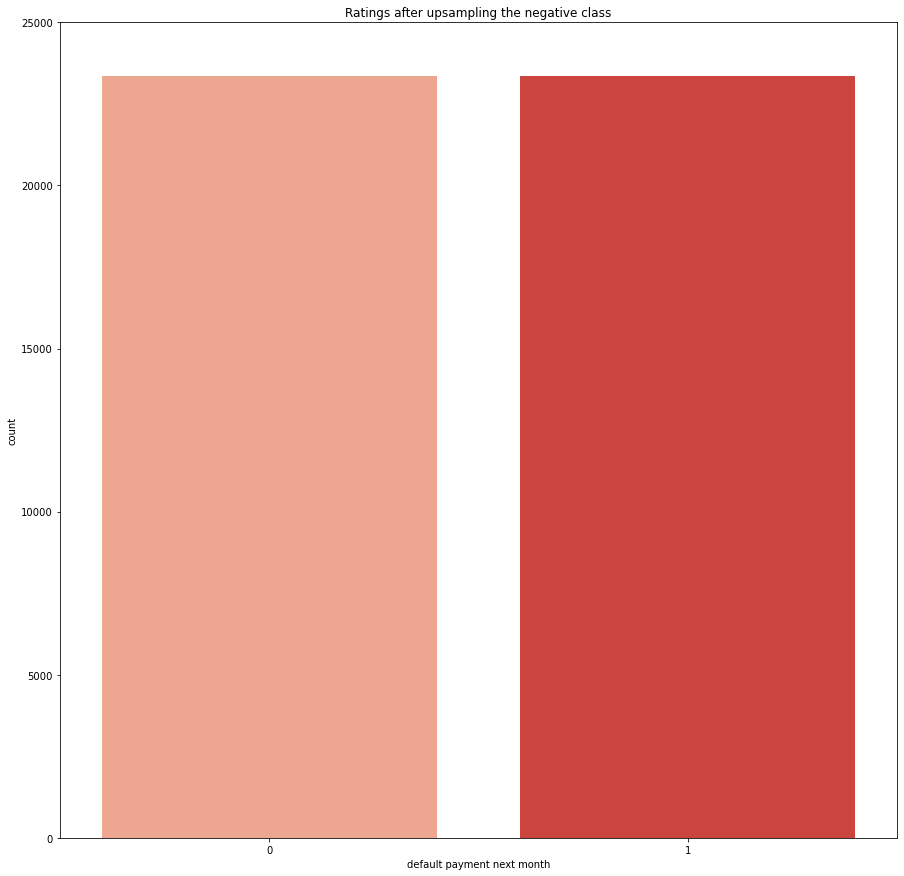

In [33]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.subplots(figsize = (15,15))
sb.countplot(x=df['default payment next month'], y = None, palette = "Reds") 
plt.title('Ratings after upsampling the negative class')
plt.yticks([0,5000,10000,15000,20000,25000])

## 5. <a name="5">Training and test datasets</a>
(<a href="#0">Go to top</a>)

We split our dataset into training (90%) and test (10%) subsets using sklearn's [__train_test_split()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [34]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df[all_features], test_size=0.2, shuffle=True, random_state=23)


## 6. <a name="6">Data processing with Pipeline and ColumnTransformer</a>
(<a href="#0">Go to top</a>)

Let's build a more complex pipeline today. We first build separate pipelines to handle the numerical, categorical, and text features, and then combine them into a composite pipeline along with an estimator, a [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) here.

   * For the numerical features pipeline, the __numerical_processor__ below, we impute missing values with the mean using sklearn's SimpleImputer, followed by a MinMaxScaler (don't have to scale features when using Decision Trees, but it's a good idea to see how to use more data transforms). If different processing is desired for different numerical features, different pipelines should be built - just like shown below for the two text features.
   
   
   * In the categoricals pipeline, the __categorical_processor__ below, we impute with a placeholder value (no effect here as we already encoded the 'nan's), and encode with sklearn's OneHotEncoder. If computing memory is an issue, it is a good idea to check categoricals' unique values, to get an estimate of many dummy features will be created by one-hot encoding. Note the __handle_unknown__ parameter that tells the encoder to ignore (rather than throw an error for) any unique value that might show in the validation/and or test set that was not present in the initial training set.
   
   
The selective preparations of the dataset features are then put together into a collective ColumnTransformer, to be finally used in a Pipeline along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset via cross-validation or making predictions on a test dataset in the future.

In [35]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('num_scaler', MinMaxScaler()) # Shown in case is needed, not a must with Decision Trees
                                ])

                  
# Preprocess the categorical features
categorical_processor = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='0')), # Shown in case is needed, no effect here as we already imputed with 'nan' strings
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')) # handle_unknown tells it to ignore (rather than throw an error for) any value that was not present in the initial training set.
                                ])

                          

# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, numeric_features),
    ('categorical_pre', categorical_processor, (text_categorical_features + numeric_categorical_features)),
                                    ]) 

### PIPELINE ###
################

# Pipeline desired all data transformers, along with an estimator at the end
# Later you can set/reach the parameters using the names issued - for hyperparameter tuning, for example
pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('dt', GradientBoostingClassifier(n_estimators=100))
                    ])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['LIMIT_BAL', 'AGE',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='0',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE', 'PAY_0', 'PAY_2',
                                                   'PAY_3', 'PAY_4', 'PAY_5',
                                                   'PAY_6'])])),
                ('dt', GradientBoostingClassifier())])

## 6. <a name="6">Train and tune a classifier</a>
(<a href="#0">Go to top</a>)

Let's first train and test the above composite pipeline on the train and the test sets.  

In [36]:
y_train = train_data[label]

y_train.head(10)

948      0
25169    0
5635     0
1691     0
29499    0
16393    0
4145     1
25586    1
29054    1
21351    0
Name: default payment next month, dtype: int64

In [37]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get train data to train the pipeline
X_train = train_data[numeric_features + text_categorical_features + numeric_categorical_features]
y_train = train_data[label]

# Fit the Pipeline to training data
pipeline.fit(X_train, y_train)

# Use the fitted pipeline to make predictions on the train dataset
train_predictions = pipeline.predict(X_train)

#this is for binary classification
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Accuracy (training):", accuracy_score(y_train, train_predictions))


# Get test data to test the pipeline
X_test = test_data[numeric_features + text_categorical_features + numeric_categorical_features]
y_test = test_data[label]

# Use the fitted pipeline to make predictions on the test dataset
test_predictions = pipeline.predict(X_test)
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Accuracy (test):", accuracy_score(y_test, test_predictions))



[[14939  3738]
 [ 6386 12311]]
              precision    recall  f1-score   support

           0       0.70      0.80      0.75     18677
           1       0.77      0.66      0.71     18697

    accuracy                           0.73     37374
   macro avg       0.73      0.73      0.73     37374
weighted avg       0.73      0.73      0.73     37374

Accuracy (training): 0.7291164981002837
[[3735  947]
 [1604 3058]]
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      4682
           1       0.76      0.66      0.71      4662

    accuracy                           0.73      9344
   macro avg       0.73      0.73      0.73      9344
weighted avg       0.73      0.73      0.73      9344

Accuracy (test): 0.7269905821917808


#### Hyperparameter Tuning

We next use sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to look for hyperparameter combinations to improve the accuracy on the test set (and reduce the generalization gap). As GridSearchCV does cross-validation train-validation split internally, 
our data transformers inside the Pipeline context will force the correct behavior of learning data transformations on the training set, and applying the transformations to the validation set when cross-validating, as well as on the test set later when running test predictions.

Also, Pipeline's steps names give easy access to hyperparameters for hyperparameter tuning while cross-validating. Parameters of the estimators in the pipeline can be accessed using the __estimator__ __ __parameter__ syntax. Note the __double underscores__ connecting the __estimator__ and __parameter__!

In [38]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df[all_features], test_size=0.2, shuffle=True, random_state=23)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### PIPELINE GRID_SEARCH ###
############################
# Get train data to train the pipeline
X_train = train_data[numeric_features + text_categorical_features + numeric_categorical_features]
y_train = train_data[label]
# Get test data to test the pipeline
X_test = test_data[numeric_features + text_categorical_features + numeric_categorical_features]
y_test = test_data[label]

# Parameter grid for GridSearch
parameters = {
    #"dt__loss":["deviance"],
    "dt__learning_rate": [0.5,0.6,0.8,1],
#    "  #"dt__min_samples_split": np.linspace(0.1, 0.5, 12),
    #"dt__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "dt__max_depth":[8,10,12],
    #"dt__max_features":["sqrt"],
    #"dt__criterion": ["friedman_mse",  "mae"],
    #"dt__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "dt__n_estimators":[30,50,70,100]
    }

grid_search = GridSearchCV(pipeline, param_grid=parameters, scoring='accuracy',n_jobs=4,iid=False, cv=5)

# Fit the GridSearch to our training data
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)

In [ ]:
# Get the best model out of GridSearchCV
classifier = grid_search.best_estimator_

# Fit the best model to the train data once more
classifier.fit(X_train, y_train)

### <a name="8">Test the classifier</a>
(<a href="#0">Go to top</a>)

Now we test the best model with the best parameters on "unseen" data (our test data).

Before that, let's first see how the model works on the training dataset.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Use the fitted model to make predictions on the train dataset
train_predictions = classifier.predict(X_train)

print('Model performance on the train set:')
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions))

And now, let's evaluate the performance of the classifier on the test set.